## Classifying the Persian Tweets Without the Use of Machine Learning Algorithms

In [1]:
import pandas as pd
import random
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
df = pd.read_csv("Data/tweets_sent_fa.csv")

In [2]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'date', 'username', 'to', 'replies',
       'retweets', 'favorites', 'text', 'mentions', 'hashtags', 'id',
       'permalink', 'text_mentions', 'text_links', 'cleaned_text', 'language',
       'sentiment', 'hate'],
      dtype='object')

In [3]:
del df['Unnamed: 0']
del df['Unnamed: 0.1']
df.columns

Index(['date', 'username', 'to', 'replies', 'retweets', 'favorites', 'text',
       'mentions', 'hashtags', 'id', 'permalink', 'text_mentions',
       'text_links', 'cleaned_text', 'language', 'sentiment', 'hate'],
      dtype='object')

### Dropping English and Arabic tweets, leaving only Persian. I made some mistakes when I labelled the training set which I have to fix.

In [4]:
df['language'].unique()

array(['fa', 'en', '10', 'ar', nan, 'بش'], dtype=object)

In [5]:
df.drop(df[df['language'].isin(["en", 'ar'])].index, inplace=True)

In [6]:
df['language'] = 'fa'

### Dropping the unnecessary characters and unifying the different variety of characters. 

In [7]:
def remove_unnecessary(txt):
    #remove extra space
    txt = txt.lower()
    txt = ' '.join(txt.split())
    
    replA = ("أ", "إ")    
    chars_to_drop = ( 'ّ', 'َ', 'ِ', 'ُ', 'ْ', 'ً', 'ٍ', 'ٌ', 'ـ' )
    chars_to_clean = ('…','#', '@', '-', '_')
    txt = txt.replace("ة","ه")
    txt = txt.replace("ي", 'ی')
    for a in replA:
        txt = txt.replace(a, "ا")
    for d in chars_to_drop:
        txt = txt.replace(d,"")
    for c in chars_to_clean:
        txt = txt.replace(c," ")
    return txt.strip()

In [8]:
df.loc[:, 'cleaned_text'] = df.loc[:, 'cleaned_text'].apply(remove_unnecessary)

### Splitting the data into labelled and unlabelled sets

In [9]:
df_s = df[df['sentiment'].isna()]
df_s.reset_index(drop = True, inplace = True)
df_s.shape

(78545, 17)

#### Dropping the irrelevant tweets (labelled 10) and properly label the rest: 'O' for tweets that oppose the assassination, 'S' for tweets that support the assassination and 'N' for neutral tweets. Note that those that are labelled '2' are also neutral

In [10]:
df_t = df.dropna(subset=['sentiment'])
df_t.drop(df_t[df_t['sentiment'] == 10].index, inplace=True)
df_t.loc[df_t['sentiment'] == 2, 'sentiment'] = 'N'
df_t.loc[df_t['sentiment'] == 0, 'sentiment'] = 'N'
df_t.loc[df_t['sentiment'] == 1, 'sentiment'] = 'O'
df_t.loc[df_t['sentiment'] == -1, 'sentiment'] = 'S'
df_t.reset_index(drop = True, inplace = True)
df_t.shape

C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\laura\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


(858, 17)

In [11]:
df_t['sentiment'].unique()

array(['N', 'S', 'O'], dtype=object)

### Determining the keywords that could indicate the sentiment of the tweets

In [12]:
su_list01 = ['درک واصل', 'کتلت', 'سپاه تروریستی', 'براندازم', 'به گا', 'مرگ بر جمهوری', ' بگا ', 'سقط', 'ارازشه', 'بیش باد', 
            ' اعتراضات سراسری' , 'پویا', 'مرگ بر خامنه', 'آبان', '۱۵۰۰', 'عرازشه', 'مقدس سازی', 'پایکوبی', 'دیکتاتور', 'حجامت', 'جاعش', 'خجسته',
            'گور میگرفتی', 'مچکریم', 'thankyou', 'خبر خوش', 'حق برگزاری', 'جشن', 'چیز خر'
            ]
su_list02 = ['هلاکت', 'پاسدار ', 'تروریست', 'آزاد', 'درک', 'عرزشی', ' عن ','ارزشی' , 'رژیم', 'دژخیم', 'اشغالگر', 'قصاب',
             'جحیم', 'آرامتر', 'آرام تر', 'چلاق', 'عاقا', 'کودک', 'نعش', 'آخوند', 'شادی عمومی',
             'متشکرم', 'متشکریم', 'پر شور', 'ینتفض', 'هلاك',  'شادانه', 'سرنگون', 'بشاش', 'protest', 'idlib', 'آتش کشید', 'شاد', 'غلط', 'بی دفاع',
             'جزغاله', 'خوشحالم', 'گا رفت', 'عرضشی' , 'آدمکش', 'بی شرف', 'قتل عام',
            ]


In [13]:
op_list = ['سردار', 'شهید', 'شهادت', 'صاحب', 'آقاجان', 'آقا جان', 'مقاومت', 'رهبر انقلاب', 'رهبرانقلاب',
           'عشق', 'عاشق', 'ایشان', 'بخون', 'کاخ سفید', 'امام', 'حضرت', 'حجت', 'عاشورا', 'شیفت شب', 'راه خدا',
           'نابود', 'تحسبن', 'صهیو', 'بغض', 'حسرت', 'رهبری', 'بیدارتر', 'انتقامی سخت', 'انتقامت'
           , 'الموت', 'لبیک', 'الفرج', 'لبيك', 'مرگ بر امر', 'مرگ بر آمر', 'اشک رهبر',
           'پیکر', 'زینب', 'هزاران قاسم', 'همه قاسم', 'من قاسم', 'علم', 'قلب ما','ماتم کده' ,
           'مالک', 'شهدا', 'شکوه', 'انقلابی', 'تفنگ پدری', 'سننتقم', 'revenge', 'down', 'روضه', 'نجس',
           'آل مروان', 'ترامپ احمق', ' گرگ', 'سازش', 'نهضت', 'ناموس', 'پرواز', 'انتقام می', 'مزدور'
           , 'روحت شاد', 'انتقام خو', 'شیر', 'یادش گر', 'لثارات', 'خون تو',
           'برکت', 'حسین', 'الهی بمیر', 'زکیه', 'آسمان', 'لعنت', 'حافظ امنیت',
           'خون پدر', 'مثل پدر', 'عطر', 'جهاد', 'سلیمانی هست', 'مدافع', 'آرزو', 'فاعتدو', 
           'امنیت ایران', 'حصیر', 'قاصم', 'دلگی', 'دوران بزن', 'مرگ بر اسر', 'صهیو', 'انتقام سخت', 'حاج'
          , 'محبوب', ' غصه ', 'کف دست', 'منتقم', 'خبر دردناک', 'کاش دروغ', 'بیگانه', 'جانش ر', 'نمک رو', 'خدا رحمت', 'آبیاری', 'پهلوان',
           'نمک نشناس', 'پا خیز', 'شیطان', 'الفراق', 'رفیق','اشک', 'کربلا', 'خوشحالها', 'خوشخالن', 'داعش', 'عزا','دست برید',
           ' کفش', 'قصاص', 'همپیمان', 'هم پیمان', 'جان و دل', 'جون و دل', 'یکپارچه', 'جسم بی جان', 'روح مطهر', 'امت ', 'ارباب ', 'عزت'
          ,'تحسبن', 'استوار', 'عاشق', 'استکبار', 'آهنگران', 'اینستاگرام' 
          ]


### Classifying using the keywords

In [14]:
op_keywords = {}
su_keywords = {}

In [15]:
def process_tweets(row):
    for i in su_list01:
        if i in row:
            if i in su_keywords:
                su_keywords[i] += 1
            else:
                su_keywords[i] = 1
            return 'S'
    for i in op_list:
        if i in row:
            if i in op_keywords:
                op_keywords[i] += 1
            else:
                op_keywords[i] = 1
            return 'O'
    for i in su_list02:
        if i in row:
            if i in su_keywords:
                su_keywords[i] += 1
            else:
                su_keywords[i] = 1
            return 'S'
    return 'N'

In [16]:
df_s.loc[:, 'sentiment'] = df_s.loc[:, 'cleaned_text'].apply(process_tweets)

In [17]:
df_op = df_s[df_s['sentiment'] == 'O']
print("Oppose: ", df_op.shape[0])
df_su = df_s[df_s['sentiment'] == 'S']
print("Suport: ", df_su.shape[0])
df_neu = df_s[df_s['sentiment'] == 'N']
print("Neutral: ", df_neu.shape[0])

Oppose:  48982
Suport:  10255
Neutral:  19308


### Printing 100 randomly-selected tweets from each category, and counting the correctly classified and misclassified ones

In [18]:
df_neu.reset_index(drop = True, inplace = True)
n = random.sample(range(df_neu.shape[0]-1), 100)
for i in n:
    print(df_neu.loc[i]['cleaned_text'])
    print("===============================")

بعضی ها در جوانی هم چیزی نبودند،انرژی جوانی باعث میشد تا کجی هاشان دیده نشود،پیر که شدند،تبدیل به کاریکاتور مضحکی شدند که بیشتر رقت انگیز می نمایند تا تنفر آمیز امثال  محمود دولت آبادی  داریوش ارجمند و... پس از کشته شدن  قاسم سلیمانی تتمه آبرو و اعتبار نداشته شان را خرج کردند
قاسم سلیمانی هم تمام قدم بعدی ... این دو هفته و روزهای آتی چه خواهد شد ؟  کلید واژه  بگو برگرد شاه
بیا! بعد شما برو خودت رو جر بده كه نه، سگ زرد برادر شعال نیست!  ظریف  قاسم سلیمانی
دیروز خیلی چیزارو فهمیدم! یه عده دیروز ناراحت ازکشته شدن  قاسم سلیمانی یه عده خوشحال چون هر کی یه اعتقادی داره و طبق عقیده خودش توییت میزنه اینجا توییتر فارسیه جای که همه اعتقاد دارن هر کی با هرعقیده میتونه حضور داشته باشه ولی دیروز نشون داد هر کی مخالف عقیده ما باشه بلاک میشه
چه مقایسه زیبا و واقعی! احسنت  قهرمان من  قاسم سلیمانی
حالا صدا سیما میاد  قاسم سلیمانی غایب شده و بعدها ظهور خواهد کرد
به گزارش خبرگزاری فارس،  آیت‌الله‌خامنه‌ای ساعتی پیش برای عرض تسلیت در خانه  قاسم سلیمانی حضور یافت.
می دانید که  برجام شما مسئول خون  قاسم سلی

In [19]:
neu = 80
su = 7
op = 13
predicted = ['N']*100
actual = ['O']*op + ['N']*neu + ['S']*su
print(len(actual))

100


In [20]:
df_op.reset_index(drop = True, inplace = True)
n = random.sample(range(df_op.shape[0]-1), 100)
for i in n:
    print(df_op.loc[i]['cleaned_text'])
    print("===============================")

شکوه مردها پیداست ولی تو رزم پیدا تر علمدارا همه زیبان ولی بی دست زیباتر...  قاسم سلیمانی
كینه هاى پاكمان را تا زمان امر ولایت فقیه در دلهایمان حفظ میكنیم و  انتقام سخت را خواهیم گرفت..  قاسم سلیمانی
قاآنی همان مخفف شده ی  قاسم سلیمانی ست فرمانده : حنا به دست ، کفن به تن ، آماده ی آماده لحظه شمار گرفتن انتقامیم.  انتقام سخت
تروریست‌ها باید بدانند که راه شهید  قاسم سلیمانی ادامه خواهد داشت ولی این کافی نیست شبیخون تروریست‌های آمریکا نباید بدون پاسخ بماند  انتقام میگیریم
چگوارا فقط بخاطر اینکه در دو کشور با آمریکا مبارزه کرد نماد مبارزه با امپریالسم بود. مقایسه کنید با  قاسم سلیمانی که به گستره یک دنیا با آمریکا مبارزه کرده است، حتی بعد از شهادتش.
فیلم دیده نشده از شهید سپهبد حاج  قاسم سلیمانی ،در حرم خانم سیده زینب سلام الله علیها
جهان سومی یعنی آمار کشته شده های تشییع جنازه بیشتر حمله تروریستی باشه !پروژه شهید سازی بار دیگر کلید خورد دهه قاسمیه شد فك كنم چند میلیون دلار امریکا هزینه کرد برای ترور  قاسم سلیمانی کلا 4.5 نفر کشته داد. تا این لحظه 40 نفر کرمان تو مراسم خاکسپاری  حاج قاسم ک

In [21]:
neu = 5
su = 9
op = 86
p = ['O']*100
a = ['O']*op + ['N']*neu + ['S']*su
print(len(a))
actual += a
predicted +=p

100


In [22]:
df_su.reset_index(drop = True, inplace = True)
n = random.sample(range(df_su.shape[0]-1), 100)
for i in n:
    print(df_su.loc[i]['cleaned_text'])
    print("===============================")

ترامپ مهم نیست، مهم این است که  قاسم سلیمانی جزء همانها بود که ۱۵۰۰ جان عزیز را کشتند و تو و امثال تو در مرگ او شیون کردید.
در انتها هم از خواستم از دوستان خواهش کنم مساله  قاسم سلیمانی را با حوادث اخیر ایران از جمله کشته شدگان آبان ماه گره نزنند. مساله مشترک این است که در حال حاضر یک سرباز بوسیله ی یک نیروی خارجی از دست رفته است.
شبکه «a haber» ترکیه به نقل از «ایندیپندت عربی» نوشت: اطلاعاتی که منجر به کشته شدن قاسم سلیمانی شد از سوی یک مقام بلند پایه رژیم اسد لو داده شد».  قاسم سلیمانی
قاسم سلیمانی با دستور ترامپ به درک واصل شد بهترین خبر واسه شروع سال جدید
به جای دو دستگی در سوگ یا جشن برای  قاسم سلیمانی ، برای  صلح و در مقابل  جنگ متحد شویم. "پیروزی ما آن چیزی نیست که در آن کسی شکست بخورد" پیام مشاوران  میرحسین موسوی :
کودکان سوری بدانند قاتلشان کشته شد.  قاسم سلیمانی
conserve of  soleimani is available کنسرو  قاسم سلیمانی موجود می‌باشد  tnxpotus4soleimani  کتلت سلیمانی  qassemsoleimani
کدام «ایران» در سوگ  قاسم سلیمانی زار می‌زند؟ ایران شما سرکوبگران و غارت‌گران یا ایران مردم زخم‌

In [23]:
neu = 10
su = 81
op = 9
p = ['S']*100
a = ['O']*op + ['N']*neu + ['S']*su
print(len(a))
actual += a
predicted +=p

100


### Most frequently used words in each category

In [24]:
op_keywords = {k: v for k, v in sorted(op_keywords.items(), key=lambda item: item[1], reverse = True)}
op_keywords

{'سردار': 12878,
 'انتقام سخت': 7495,
 'شهید': 5821,
 'شهادت': 4133,
 'حاج': 1508,
 'revenge': 1508,
 'امام': 921,
 'مقاومت': 738,
 'نابود': 643,
 'شیر': 625,
 'مرگ بر آمر': 563,
 'انتقامی سخت': 545,
 'علم': 457,
 'عزا': 441,
 'حسین': 427,
 'داعش': 426,
 'سننتقم': 425,
 'شهدا': 389,
 'عشق': 324,
 'صاحب': 313,
 'انتقام می': 300,
 'حضرت': 297,
 'پیکر': 295,
 'ایشان': 290,
 'عاشق': 284,
 'رهبری': 277,
 'سلیمانی هست': 257,
 'زینب': 251,
 'انتقام خو': 224,
 'بغض': 220,
 'مزدور': 207,
 'تفنگ پدری': 204,
 'اینستاگرام': 201,
 'پرواز': 186,
 'مالک': 185,
 'لعنت': 184,
 'اشک': 177,
 'الفرج': 172,
 'صهیو': 164,
 'انقلابی': 162,
 'لبیک': 154,
 'بخون': 149,
 'کاخ سفید': 144,
 'امت ': 143,
 'آرزو': 139,
 'رهبر انقلاب': 137,
 'جهاد': 132,
 'قاصم': 129,
 'محبوب': 123,
 'روضه': 113,
 'آسمان': 112,
 'ناموس': 104,
 'down': 99,
 'مدافع': 88,
 'بیدارتر': 88,
 'انتقامت': 85,
 'دوران بزن': 81,
 'عاشورا': 81,
 'الموت': 76,
 'شیطان': 75,
 ' گرگ': 70,
 'مرگ بر امر': 70,
 'برکت': 68,
 'کربلا': 67,
 'سازش': 66,
 

In [25]:
su_keywords = {k: v for k, v in sorted(su_keywords.items(), key=lambda item: item[1], reverse = True)}
su_keywords

{'درک واصل': 1326,
 'تروریست': 1055,
 'آبان': 1016,
 'سقط': 614,
 'کتلت': 563,
 'براندازم': 435,
 'رژیم': 427,
 'آزاد': 326,
 'جشن': 312,
 'هلاکت': 295,
 'پویا': 278,
 'شاد': 274,
 'چیز خر': 274,
 ' اعتراضات سراسری': 266,
 'غلط': 234,
 '۱۵۰۰': 213,
 'سپاه تروریستی': 182,
 'درک': 167,
 'دیکتاتور': 166,
 'کودک': 122,
 'عرزشی': 109,
 'protest': 102,
 'پایکوبی': 101,
 'حجامت': 89,
 'به گا': 88,
 ' بگا ': 86,
 'ارزشی': 80,
 'آخوند': 76,
 'مرگ بر خامنه': 76,
 'خوشحالم': 69,
 'پاسدار ': 68,
 'thankyou': 63,
 'بی شرف': 59,
 'عرازشه': 54,
 'مرگ بر جمهوری': 49,
 'جاعش': 45,
 'سرنگون': 41,
 'بیش باد': 38,
 'هلاك': 32,
 'حق برگزاری': 32,
 'قصاب': 29,
 'شادی عمومی': 27,
 'خبر خوش': 24,
 'قتل عام': 24,
 'نعش': 23,
 ' عن ': 22,
 'آدمکش': 22,
 'گور میگرفتی': 20,
 'آتش کشید': 19,
 'عاقا': 17,
 'جحیم': 16,
 'چلاق': 14,
 'شادانه': 11,
 'خجسته': 10,
 'بی دفاع': 10,
 'مقدس سازی': 9,
 'جزغاله': 8,
 'دژخیم': 8,
 'ینتفض': 8,
 'اشغالگر': 6,
 'مچکریم': 6,
 'ارازشه': 4,
 'بشاش': 4,
 'پر شور': 4,
 'متشکرم': 3,
 '

### Confusion Matrix

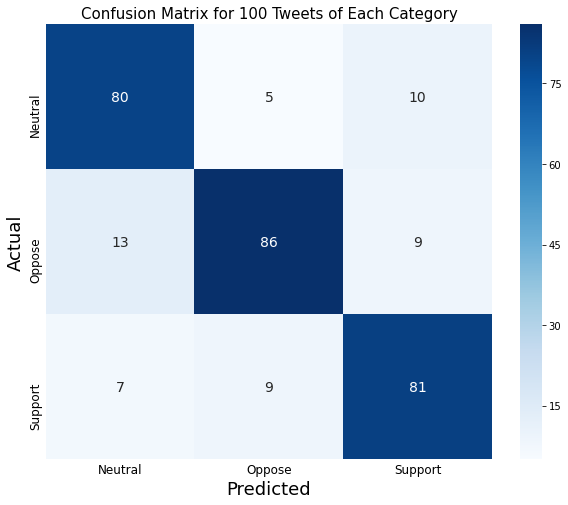

In [29]:
actu = np.array(actual)
predic = np.array(predicted)

confm = confusion_matrix(actu, predic)
c = [ 'Neutral', 'Oppose', 'Support']
df_cm = pd.DataFrame(confm, index=c, columns=c)
plt.subplots(figsize=(10,8))
ax = sn.heatmap(df_cm, cmap='Blues', annot=True, annot_kws={"fontsize":14})
xticks = ax.xaxis.get_major_ticks()
yticks = ax.yaxis.get_major_ticks()
for ts in [xticks, yticks]:
    for t in ts:
        t.label.set_fontsize(12)

ax.tick_params(axis='both', which='both',length=0)
ax.set_title('Confusion Matrix for 100 Tweets of Each Category', fontsize = 15)
ax.set_ylabel('Actual', fontsize = 18)
ax.set_xlabel('Predicted', fontsize = 18);

In [27]:
df_final = pd.concat([df_t, df_s])

In [28]:
df_final.to_csv("Data/tweets_fa_classified.csv", index = False)